In [362]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [152]:
sns.set(rc={'figure.figsize':(9,6)})

In [153]:
events_data = pd.read_csv('C:/Users/User/jupyter_pr/data_frames/event_data_train.csv')

In [154]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [155]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [156]:
events_data['day'] = events_data.date.dt.date

In [157]:
events_data.head(10)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


<AxesSubplot:xlabel='day'>

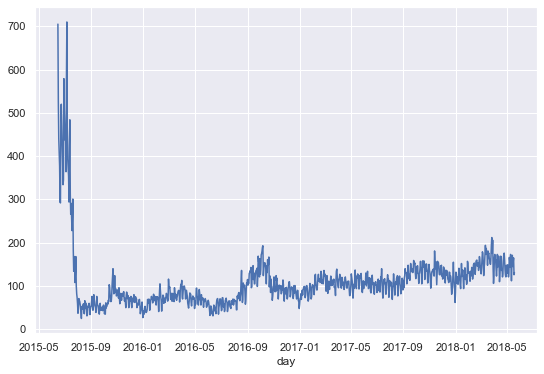

In [158]:
events_data.groupby('day') \
    .user_id.nunique().plot()

In [159]:
users_events_data = events_data.pivot_table(columns='action',
                        index='user_id',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().sort_values('started_attempt', ascending=False)

In [160]:
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
781,1046,128,124,721,8122
2611,3572,194,193,550,6968
6062,8394,131,94,337,1070
4825,6662,198,197,285,1054
1204,1649,194,194,281,807
...,...,...,...,...,...
4959,6846,1,1,0,1
12468,17307,1,1,0,1
4961,6848,12,11,0,14
4962,6849,1,1,0,17


In [161]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')

In [162]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [163]:
submissions_data['day'] = submissions_data.date.dt.date

In [164]:
users_scores = submissions_data.pivot_table(columns='submission_status',
                        index='user_id',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [165]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [166]:
pd.DataFrame(events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).apply(len).sort_values(ascending=False).head(15))

,timestamp
user_id,
1046,477
13268,384
4374,326
10794,280
3572,235
20907,220
2054,183
23342,178
39,169


In [167]:
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [168]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [169]:
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

In [170]:
gap_data = gap_data / (24 * 3600)

<AxesSubplot:>

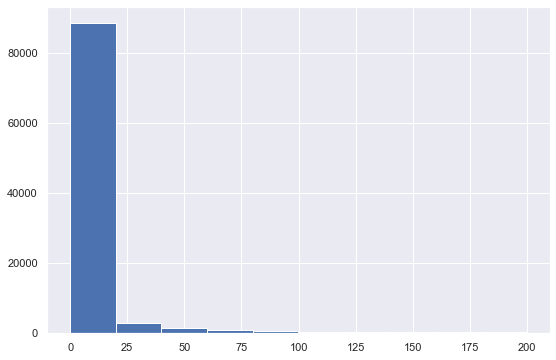

In [171]:
gap_data[gap_data < 200].hist()

In [172]:
gap_data.quantile(0.9)

18.325995370370403

In [173]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [174]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [175]:
now = 1526772811
drop_out_threshold = 30 * 24 * 3600

In [176]:
users_data['is_gone_user'] = now - users_data.last_timestamp > drop_out_threshold

In [177]:
users_data.value_counts('is_gone_user')

is_gone_user
True     17844
False     1390
dtype: int64

In [178]:
users_data = users_data.merge(users_scores, how='outer')

In [179]:
users_data = users_data.fillna(0)

In [180]:
users_data = users_data.merge(users_events_data, how='outer', on='user_id')

In [181]:
users_days = events_data.groupby('user_id', as_index=False).day.nunique()

In [182]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [183]:
users_data = users_data.merge(users_days, how='outer', on='user_id')

In [184]:
users_data['passed_cource'] = users_data.passed > 170

In [185]:
users_data.passed_cource.value_counts()

False    17809
True      1425
Name: passed_cource, dtype: int64

In [186]:
users_data[users_data.user_id == 1046]

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_cource
781,1046,1525160857,False,421.0,513.0,128,124,721,8122,478,False


In [187]:
########################### Second Part ###########################

<AxesSubplot:>

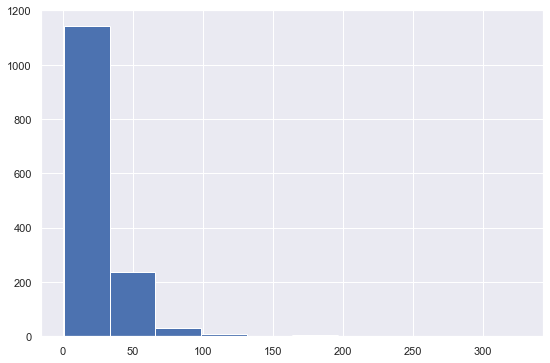

In [215]:
users_data[users_data.passed_cource].day.hist()

In [309]:
user_min_time = events_data.groupby('user_id' , as_index=False) \
    .agg({'timestamp':'min'}) \
    .rename({'timestamp':'min_timestamp'} , axis=1)

In [310]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [311]:
users_data = users_data.merge(user_min_time , how='outer')

In [312]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + \
    (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [313]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [314]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [315]:
learning_time_treshhold =  30 * 24 *60 * 60

In [316]:
events_data = events_data = events_data.merge(user_min_time[['user_id','user_learning_time_treshold']] , how='outer')

In [317]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [318]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275.0,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300.0,15853_1434605177
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149.0,15853_1434605177
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164.0,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123.0,15853_1434605177


In [319]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [320]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'day':'days'}, axis=1)

In [321]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename({'step_id':'step_tries'}, axis=1)

In [322]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [323]:
X = X.merge(submissions_data_train.pivot_table(columns='submission_status',
                        index='user_id',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index())

In [324]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [325]:
X = X.merge(events_data_train.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()[['user_id','viewed']],how='outer')

In [326]:
X = X.fillna(0)

In [327]:
X = X.merge(users_data[['user_id', 'passed_cource', 'is_gone_user']], how='outer')

In [328]:
X = X[~((X.is_gone_user == False) & (X.passed_cource == False))]

In [329]:
y = X.passed_cource

In [330]:
y = y.map(int)

In [331]:
X = X.drop(['passed_cource', 'is_gone_user'], axis=1)

In [332]:
X = X.set_index('user_id')

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [356]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2)

In [357]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7)

In [349]:
#best_clf = grid_search_clf.best_estimator_

In [358]:
y_pred = clf.predict(X_test)

In [363]:
accuracy_score(y_test, y_pred)

0.926605504587156

In [360]:
precision_score(y_test, y_pred)

0.7272727272727273

In [136]:
submits = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')

In [150]:
submits[submits.submission_status == 'wrong'] \
    .groupby(['user_id', 'step_id'], as_index=False) \
    .agg({'timestamp':'max'}).step_id.value_counts()

31978    3423
32031    3255
31972    3064
32202    2614
31971    2517
         ... 
33681     300
31986     274
33998     251
32175     199
32929      59
Name: step_id, Length: 76, dtype: int64